In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import tqdm
from einops import rearrange
import numpy as np
import pytorch_lightning
import matplotlib.pyplot as plt
from pytorch_lightning.utilities import move_data_to_device

from case_studies.dc2_mdt.utils.gaussian_diffusion import (GaussianDiffusion,
                                                           get_named_beta_schedule,
                                                           ModelMeanType,
                                                           ModelVarType,
                                                           LossType)
from case_studies.dc2_mdt.utils.respace import space_timesteps, SpacedDiffusion
from case_studies.dc2_mdt.utils.resample import create_named_schedule_sampler, ScheduleSampler, SpeedSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 4
max_objects = 2
image_normalize_strategy = "linear_scale"

In [4]:
# class SimpleMLP(nn.Module):
#     def __init__(self, layers, hidden_ch):
#         super().__init__()

#         self.network = nn.Sequential(
#             nn.Linear(1 + 1 + 16, hidden_ch),
#             nn.ReLU(),
#             *[
#                 nn.Sequential(
#                     nn.Linear(hidden_ch, hidden_ch),
#                     nn.LayerNorm(hidden_ch),
#                     nn.ReLU(),
#                 ) for _ in range(layers)
#             ],
#             nn.Linear(hidden_ch, 1)
#         )
    
#     def forward(self, x, t, image):
#         x = torch.cat([x, t.unsqueeze(1), image.flatten(start_dim=1)], dim=1)
#         return self.network(x)

In [5]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size * max_objects, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + 1, hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

    def forward(self, x, t, image, noise_tag):
        t = t.unsqueeze(-1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange([sin_embed_t, cos_embed_t], "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, noise_tag], dim=-1)
        )
        return out.view(x.shape)

In [32]:
device = torch.device("cuda:7")
batch_size = 1024
val_batch_size = 1000
training_time_steps = 1000
training_iters = 10_000
val_iters = 500
ddim_steps = 100
ddim_eta = 0.0
log_freq = 500
seed = 7272
pytorch_lightning.seed_everything(seed)

Seed set to 7272


7272

In [33]:
diffusion_config = {
    "betas": get_named_beta_schedule("linear", training_time_steps),
    "model_mean_type": ModelMeanType.EPSILON,
    "model_var_type": ModelVarType.FIXED_LARGE,
    "loss_type": LossType.MSE
}
training_diffusion = GaussianDiffusion(**diffusion_config)
sampling_diffusion = SpacedDiffusion(use_timesteps=space_timesteps(training_time_steps, f"ddim{ddim_steps}"),
                                      **diffusion_config)
schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0 if image_size > 1 else 0.1,
                                 flux_alpha=10.0,
                                 flux_beta=0.01).to(device=device)

In [8]:
my_net = FourierMLP(data_shape=[1,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
# my_net = SimpleMLP(layers=8, hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [9]:
# max_flux_boundary = 3000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [10]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (flux / max_flux_boundary) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [11]:
def mix_self_predicted_noise(q_sample_fn, 
                             p_mean_var_fn, 
                             pred_eps_from_xstart_fn, 
                             model, x_start, t, model_kwargs, 
                             mix_threshold):
    model.eval()
    with torch.inference_mode():
        ori_noise = torch.randn_like(x_start)  # (b, 1)
        xt = q_sample_fn(x_start, t, noise=ori_noise)
        out_dict = p_mean_var_fn(model, xt, t, clip_denoised=True, model_kwargs=model_kwargs)
        pred_noise = pred_eps_from_xstart_fn(xt, t, out_dict["pred_xstart"])
    model.train()
    noise_tag = torch.rand_like(ori_noise) > mix_threshold
    return torch.where(noise_tag, pred_noise, ori_noise), noise_tag

In [12]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    target_fluxes = catalog["fluxes"][:, 0:1]  # (b, 1)
    input_image = catalog["images"].permute([0, 3, 1, 2])  # (b, m, h, w)
    match image_normalize_strategy:
        case "none":
            pass
        case "log":
            input_image = torch.log1p(input_image)
        case "linear_scale":
            input_image = input_image / 1000
        case _:
            raise NotImplementedError()
    x_start = encode_flux(target_fluxes)
    mixed_noise, noise_tag = mix_self_predicted_noise(training_diffusion.q_sample,
                                                      training_diffusion.p_mean_variance,
                                                      training_diffusion._predict_eps_from_xstart,
                                                        my_net, 
                                                        x_start, 
                                                        t, 
                                                        model_kwargs={"image": input_image,
                                                                      "noise_tag": torch.ones_like(x_start, dtype=torch.bool)},
                                                        mix_threshold=0.9)
    train_loss_args = {
        "model": my_net,
        "x_start": x_start,
        "t": t,
        "loss_weights": batch_loss_weights,
        "noise": mixed_noise,
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image,
                                                            "noise_tag": noise_tag})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  5%|▌         | 508/10000 [00:09<02:48, 56.38it/s]

[500/10000] loss: 3.574e-02


 10%|█         | 1006/10000 [00:18<02:36, 57.54it/s]

[1000/10000] loss: 3.053e-02


 15%|█▌        | 1510/10000 [00:27<02:31, 55.98it/s]

[1500/10000] loss: 3.431e-02


 20%|██        | 2010/10000 [00:36<02:28, 53.87it/s]

[2000/10000] loss: 3.212e-02


 25%|██▌       | 2507/10000 [00:44<01:49, 68.65it/s]

[2500/10000] loss: 3.145e-02


 30%|███       | 3009/10000 [00:52<02:04, 56.01it/s]

[3000/10000] loss: 3.267e-02


 35%|███▌      | 3507/10000 [01:01<01:55, 56.09it/s]

[3500/10000] loss: 3.245e-02


 40%|████      | 4011/10000 [01:10<01:46, 56.07it/s]

[4000/10000] loss: 2.331e-02


 45%|████▌     | 4509/10000 [01:19<01:35, 57.67it/s]

[4500/10000] loss: 1.944e-02


 50%|█████     | 5010/10000 [01:28<01:27, 57.23it/s]

[5000/10000] loss: 2.461e-02


 55%|█████▌    | 5510/10000 [01:36<01:20, 55.90it/s]

[5500/10000] loss: 2.526e-02


 60%|██████    | 6008/10000 [01:45<01:10, 56.79it/s]

[6000/10000] loss: 2.336e-02


 65%|██████▌   | 6506/10000 [01:54<01:02, 56.19it/s]

[6500/10000] loss: 2.340e-02


 70%|███████   | 7010/10000 [02:03<00:53, 56.19it/s]

[7000/10000] loss: 2.174e-02


 75%|███████▌  | 7508/10000 [02:12<00:43, 56.65it/s]

[7500/10000] loss: 2.781e-02


 80%|████████  | 8006/10000 [02:20<00:34, 57.75it/s]

[8000/10000] loss: 2.595e-02


 85%|████████▌ | 8511/10000 [02:29<00:25, 57.93it/s]

[8500/10000] loss: 3.014e-02


 90%|█████████ | 9009/10000 [02:37<00:16, 58.60it/s]

[9000/10000] loss: 2.769e-02


 95%|█████████▌| 9509/10000 [02:46<00:08, 57.00it/s]

[9500/10000] loss: 2.493e-02


100%|██████████| 10000/10000 [02:55<00:00, 57.12it/s]

[10000/10000] loss: 2.461e-02


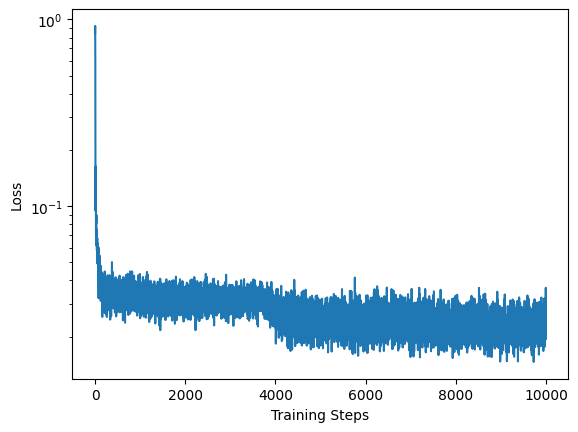

In [13]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [34]:
my_net.eval()
val_true_fluxes = None
val_est_fluxes = []
with torch.inference_mode():
    val_catalog = image_simulator.generate(batch_size=val_batch_size, 
                                               seed=seed)
    for i in tqdm.tqdm(list(range(val_iters))):
        target_fluxes = val_catalog["fluxes"][:, 0:1]  # (b, 1)
        if val_true_fluxes is None:
            val_true_fluxes = target_fluxes
        else:
            assert torch.allclose(val_true_fluxes, target_fluxes)
        input_image = val_catalog["images"].permute([0, 3, 1, 2])
        match image_normalize_strategy:
            case "none":
                pass
            case "log":
                input_image = torch.log1p(input_image)
            case "linear_scale":
                input_image = input_image / 1000
            case _:
                raise NotImplementedError()
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (val_batch_size, 1),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image,
                             "noise_tag": torch.ones((val_batch_size, 1), 
                                                     device=input_image.device, 
                                                     dtype=torch.bool)}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_fluxes.append(decode_flux(sample).cpu())
val_est_fluxes = torch.stack(val_est_fluxes, dim=0)

100%|██████████| 500/500 [01:59<00:00,  4.17it/s]


In [35]:
val_true_fluxes = val_true_fluxes.cpu()

In [36]:
val_true_fluxes.shape

torch.Size([1000, 1])

In [37]:
val_est_fluxes.shape

torch.Size([500, 1000, 1])

In [38]:
torch.mean((val_true_fluxes - val_est_fluxes) ** 2)

tensor(112997.3516)

In [39]:
torch.mean(torch.abs(val_true_fluxes - val_est_fluxes))

tensor(213.5726)

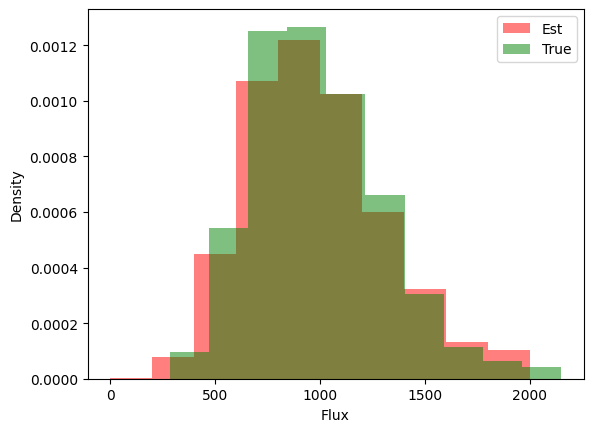

In [40]:
plt.hist(val_est_fluxes.flatten(), color="red", alpha=0.5, density=True, label="Est")
plt.hist(val_true_fluxes.flatten(), color="green", alpha=0.5, density=True, label="True")
plt.ylabel("Density")
plt.xlabel("Flux")
plt.legend()
plt.show()

In [41]:
ci_cover = torch.tensor([i / 100 for i in range(5, 100, 5)])
left_q_points = [(1.0 - c) / 2 for c in ci_cover]
right_q_points = [1.0 - lq for lq in left_q_points]
actual_ci_cover = []
for q in zip(left_q_points, right_q_points):
    q = torch.tensor(q)
    est_fluxes_q = val_est_fluxes.quantile(q=q, dim=0).permute([1, 2, 0])  # (b, 1, 2)
    above_lower_bound = val_true_fluxes[:, 0] > est_fluxes_q[:, 0, 0]
    below_upper_bound = val_true_fluxes[:, 0] < est_fluxes_q[:, 0, 1]
    actual_ci_cover.append((above_lower_bound & below_upper_bound).sum() / val_true_fluxes.shape[0])

In [42]:
actual_ci_cover = torch.cat([a.unsqueeze(0) for a in actual_ci_cover])

In [43]:
actual_ci_cover

tensor([0.0470, 0.1200, 0.2040, 0.2980, 0.3860, 0.4680, 0.5300, 0.5960, 0.6570,
        0.7020, 0.7590, 0.7980, 0.8350, 0.8730, 0.9120, 0.9320, 0.9600, 0.9720,
        0.9850])

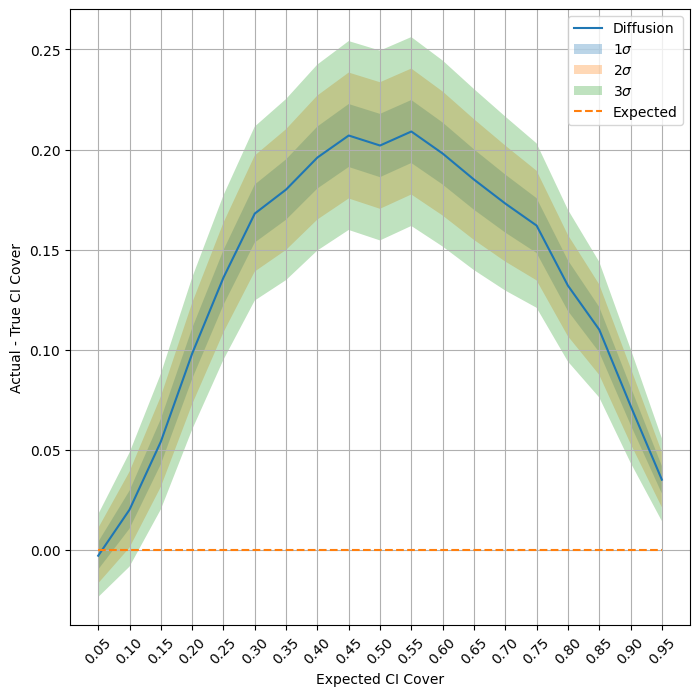

In [44]:
plt.figure(figsize=(8, 8))
a_m_c = actual_ci_cover - ci_cover
ci_sigma = (ci_cover * (1 - ci_cover) / val_batch_size) ** 0.5
plt.plot(ci_cover, a_m_c, label="Diffusion")
plt.fill_between(ci_cover, a_m_c - ci_sigma, a_m_c + ci_sigma, alpha=0.3, label=r"$1\sigma$")
plt.fill_between(ci_cover, a_m_c - 2 * ci_sigma, a_m_c + 2 * ci_sigma, alpha=0.3, label=r"$2\sigma$")
plt.fill_between(ci_cover, a_m_c - 3 * ci_sigma, a_m_c + 3 * ci_sigma, alpha=0.3, label=r"$3\sigma$")
plt.plot(ci_cover, torch.zeros_like(ci_cover), linestyle="dashed", label="Expected")
plt.legend(loc="upper right")
plt.grid()
plt.xticks(ci_cover, rotation=45)
plt.xlabel("Expected CI Cover")
plt.ylabel("Actual - True CI Cover")
plt.show()

In [45]:
val_catalog = move_data_to_device(val_catalog, "cpu")

In [46]:
true_post_dist = image_simulator.post_dist(val_catalog)

In [47]:
(-1 * true_post_dist.log_prob(val_est_fluxes.squeeze(-1))).mean()

tensor(inf)

In [48]:
(-1 * true_post_dist.log_prob(true_post_dist.sample((val_iters, )))).mean()

tensor(5.4515)

In [49]:
def wasserstein_distance(est_samples: torch.Tensor, true_samples: torch.Tensor):
    assert est_samples.ndim == 2  # (val_iters, val_batch_size)
    assert est_samples.shape == true_samples.shape
    sorted_true_samples = torch.sort(true_samples, dim=0, descending=False)[0]
    sorted_est_samples = torch.sort(est_samples, dim=0, descending=False)[0]
    return torch.abs(sorted_est_samples - sorted_true_samples).mean(dim=0)  # (b, )

In [50]:
wasserstein_distance(val_est_fluxes.squeeze(-1), true_post_dist.sample((val_iters, )).cpu()).mean()

tensor(32.4602)

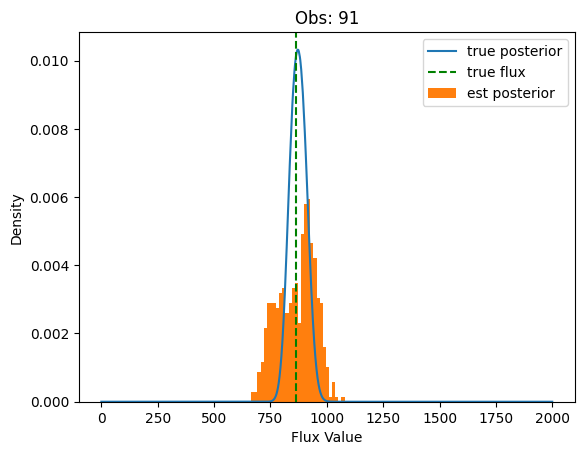

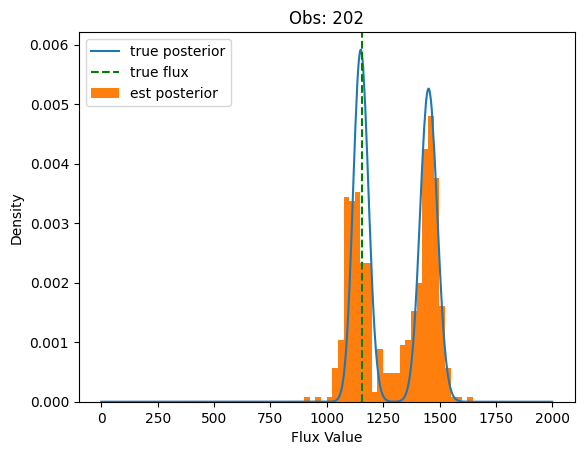

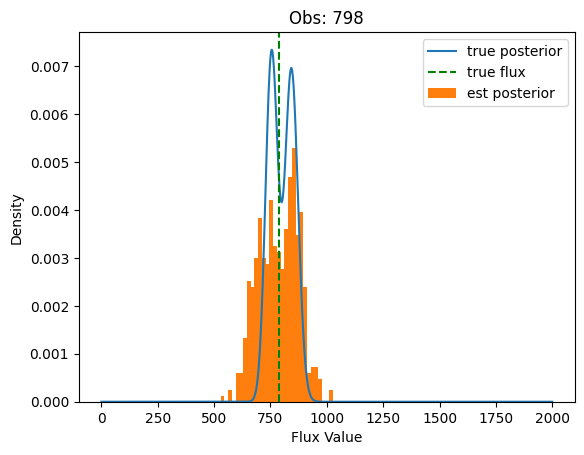

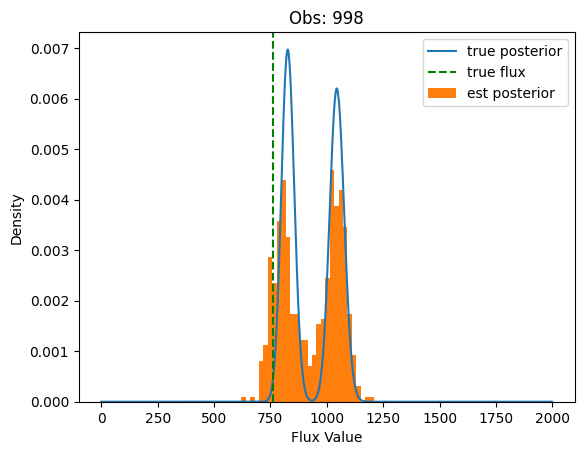

In [51]:
x = torch.linspace(0, 2000, 5000)
obs_index = [91, 202, 798, 998]
for i in obs_index:
    plt.plot(x, true_post_dist.log_prob(x.view(-1, 1))[:, i].exp().cpu(), label="true posterior")
    plt.axvline(x=val_true_fluxes[i].item(), color="green", linestyle="dashed", label="true flux")
    plt.hist(val_est_fluxes[:, i, 0].cpu(), density=True, bins=30, label="est posterior")
    plt.legend()
    plt.xlabel("Flux Value")
    plt.ylabel("Density")
    plt.title(f"Obs: {i}")
    plt.show()